In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

from GaHaCo.src.visualization import halo_mass_function as hmf

In [2]:
DATA_PATH = '/cosma5/data/dp004/hvrn44/HOD/'
HALO_MASS_CUT = 1.e11 #solar masses

## Matching halos in the DMO and HYDRO simulations

In [3]:
matching_df = pd.read_csv(DATA_PATH + 'MatchedHaloes_L205n2500.dat',
                         delimiter = ' ', skiprows = 1,
        names = ['ID_DMO', 'ID_HYDRO', 'M200_DMO', 'M200_HYDRO'])

In [4]:
matching_df

,ID_DMO,ID_HYDRO,M200_DMO,M200_HYDRO
0,0,0,1.021000e+15,1.040000e+15
1,1,1,8.764000e+14,8.856000e+14
2,2,2,6.446000e+14,7.000000e+14
3,3,3,5.923000e+14,6.094000e+14
4,4,4,5.618000e+14,5.702000e+14
...,...,...,...,...
507535,233452,17621455,1.074000e+11,1.121000e+09
507536,64861,17622524,4.568000e+11,4.780000e+08
507537,106353,17622884,2.592000e+11,7.641000e+08
507538,39555,17623990,6.809000e+11,6.064000e+08


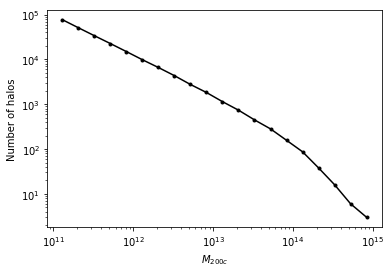

In [5]:
hmf.plot_halo_mass_function(matching_df.drop_duplicates(subset = 'ID_DMO')['M200_DMO'])


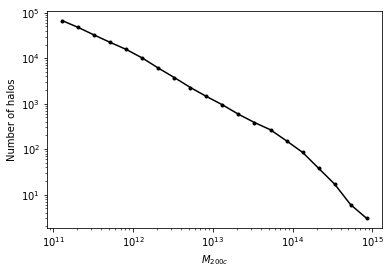

In [6]:
hmf.plot_halo_mass_function(matching_df['M200_HYDRO'])

In [7]:
print(f'There are {len(np.unique(matching_df.ID_DMO))} unique haloes in the Dark matter only simulation')
print(f'There are {len(np.unique(matching_df.ID_HYDRO))} haloes in the hydro simulation')

There are 228051 unique haloes in the Dark matter only simulation
There are 507540 haloes in the hydro simulation


## Halo mass cut on the DMO ones

In [8]:
mass_matching_df = matching_df.loc[matching_df['M200_HYDRO'] > HALO_MASS_CUT]

In [9]:
print(f'There are {len(np.unique(mass_matching_df.ID_DMO))} unique haloes above {HALO_MASS_CUT:.1E}'
      ' solar masses in the Dark matter only simulation')

There are 207006 unique haloes above 1.0E+11 solar masses in the Dark matter only simulation


In [10]:
print(f'There are {len(np.unique(mass_matching_df.ID_HYDRO))} unique haloes above {HALO_MASS_CUT:.1E}'
      ' solar masses in the Hydro simulation')

There are 211124 unique haloes above 1.0E+11 solar masses in the Hydro simulation


In [11]:
# keep only unique matchings

idx, count = np.unique(mass_matching_df.ID_DMO, return_counts=True)

Text(0.5,0,'Number of hydro haloes matched to the same DMO halo')

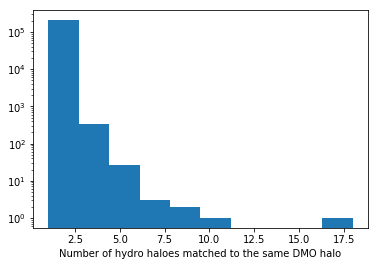

In [12]:
plt.hist(count, log = True)
plt.xlabel('Number of hydro haloes matched to the same DMO halo')

In [13]:
#unique_dmo_idx = idx[count == 1]
#unique_matching_df = mass_matching_df.loc[mass_matching_df.ID_DMO.isin(unique_dmo_idx)]

## Adding some halo properties from DMO sims

In [14]:
with h5py.File(DATA_PATH + 'HaloProfiles_DMO_z0.00_ext.hdf5', 'r') as hf:
        
       
    mass = hf['Haloes']['M200'][:]
    vmax = hf['Haloes']['Vmax'][:]
    rmax = hf['Haloes']['Rmax'][:]
    r200c = hf['Haloes']['R200'][:]
    cnfw = hf['Haloes']['Cnfw'][:]
    rhosnfw = hf['Haloes']['Rhosnfw'][:]

    massprofile = hf['Haloes']['DMMassProfile'][:]

    parametrized_cnfw = vmax/(rmax * 70)

    properties_ids = hf['Haloes']['GroupNumber'][:]

In [15]:
properties = np.vstack([properties_ids,mass, vmax, rmax,
                                     r200c, cnfw, rhosnfw]).T

In [16]:
idx, count = np.unique(mass_matching_df.ID_DMO, return_counts=True)

properties_df = pd.DataFrame(data = properties,
                             columns = ['ID_DMO', 'M200c', 'Vmax', 'Rmax', 
                                        'R200c', 'Cnfw', 'Rhosnfw'])

In [17]:
properties_df

,ID_DMO,M200c,Vmax,Rmax,R200c,Cnfw,Rhosnfw
0,0.0,1.021094e+15,1720.320608,1.017927,1637.737427,5.698943e+00,3.148591e+06
1,1.0,8.763998e+14,1626.658679,1.095801,1556.385864,4.528827e+00,1.890909e+06
2,2.0,6.445536e+14,1435.573084,0.915569,1404.871216,5.604312e+00,2.870591e+06
3,3.0,5.922584e+14,1418.062988,0.788401,1365.790283,4.750148e+00,2.012141e+06
4,4.0,5.617762e+14,1398.909960,0.767208,1341.978027,5.069929e+00,2.391334e+06
...,...,...,...,...,...,...,...
229260,278079.0,1.007831e+11,103.223734,0.014772,75.686066,5.608999e+01,1.312776e+09
229261,278541.0,1.001213e+11,109.084942,0.011484,75.523170,7.382515e+01,2.832885e+09
229262,279423.0,1.003104e+11,108.027972,0.012738,75.567726,5.663748e+01,1.331717e+09
229263,279745.0,1.006413e+11,117.696697,0.012200,75.648079,3.588773e+07,2.795470e+26


In [18]:
merged_matching_df = pd.merge(mass_matching_df, properties_df, on = ['ID_DMO'], how = 'inner')


## Adding properties from the merger tree info

In [19]:
 
with h5py.File(DATA_PATH + 'MergerTree_L205n2500TNG_DM_ext_New.hdf5',
               'r') as hf:

    
    formation_time = hf['Haloes']['z0p50'][:]
    n_mergers = hf['Haloes']['NMerg'][:]
    mass_peak = hf['Haloes']['Mpeak'][:]
    main_prog_mass = hf['Haloes']['MainProgMass'][:]
    vpeak = hf['Haloes']['Vpeak'][:]
    
    mergertree_ids = hf['Haloes']['Index'][:]


In [20]:
mergertree_data = np.vstack([mergertree_ids, formation_time, n_mergers,
                            mass_peak, vpeak]).T

In [21]:
mergertree_df = pd.DataFrame(data = mergertree_data, 
                columns = ['ID_DMO', 'Formation Time', 'Nmergers','MassPeak', 'vpeak'])

In [22]:
merged_tree_df = pd.merge(merged_matching_df,
                          mergertree_df, on = ['ID_DMO'], how = 'inner')


## Add more features from TNG

In [23]:
tng_path = '/cosma6/data/dp004/dc-cues1/tng_dataframes/'

dmo_file =  'dmo_halos.hdf5'

dmo_df = pd.read_hdf(tng_path + dmo_file)


In [24]:
dmo_merged_df = pd.merge(merged_tree_df, dmo_df, on = ['ID_DMO'], how = 'inner')


In [25]:
dmo_merged_df = dmo_merged_df.drop(columns = ['Group_M_Crit200'])
dmo_merged_df = dmo_merged_df.drop(columns = ['Group_R_Crit200'])


In [26]:
hydro_file = 'hydro_galaxies.hdf5'

hydro_df = pd.read_hdf(tng_path + hydro_file)

hydro_merged_df = pd.merge(dmo_merged_df, hydro_df, on = ['ID_HYDRO'], how = 'inner', suffixes = ('_dmo', '_hydro'))
hydro_merged_df = hydro_merged_df.drop(columns = ['Group_M_Crit200', 'M200_DMO'])


In [27]:
agg_df = hydro_merged_df.groupby('ID_DMO')['N_gals'].sum()
no_duplicates_df = hydro_merged_df.drop_duplicates(subset = 'ID_DMO', keep = 'last')

no_duplicates_df = pd.merge(no_duplicates_df, agg_df.to_frame('N_gals_total').reset_index())
no_duplicates_df = no_duplicates_df.drop(columns = ['N_gals'])
no_duplicates_df.rename(columns = {'N_gals_total':'N_gals'}, inplace = True)

Text(0.5,0,'N galaxies')

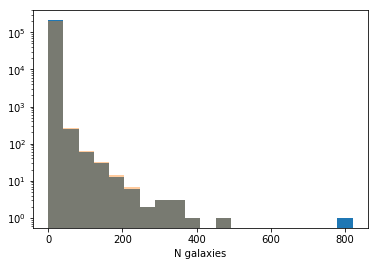

In [28]:
_, bins, _ = plt.hist(hydro_merged_df.N_gals, bins = 20,
                     log = True)

_ = plt.hist(no_duplicates_df.N_gals, log = True, alpha = 0.4, bins = bins)

plt.xlabel('N galaxies')

In [29]:
n_centrals = no_duplicates_df.N_gals > 0
n_satellites = np.where(no_duplicates_df.N_gals > 0, no_duplicates_df.N_gals - 1, 0)

In [30]:
nbins= 20
bins = np.logspace(np.log10(np.min(no_duplicates_df.M200c)),
                   np.log10(np.max(no_duplicates_df.M200c)), nbins+1)

bin_centers = (bins[1:]+bins[:-1])/2.


n_centrals_binned, edges, _ = binned_statistic(no_duplicates_df.M200c,
                                    n_centrals,
                                    statistic = 'mean',
                                    bins=bins)

n_centrals_error, edges, _ = binned_statistic(no_duplicates_df.M200c,
                                    n_centrals, 
                                    statistic = 'std',
                                    bins=bins)

In [31]:
n_satellites_binned, edges, _ = binned_statistic(no_duplicates_df.M200c, 
                                    n_satellites,
                                    statistic = 'mean',
                                    bins=bins)

n_satellites_error, edges, _ = binned_statistic(no_duplicates_df.M200c,
                                    n_satellites, 
                                    statistic = 'std',
                                    bins=bins)

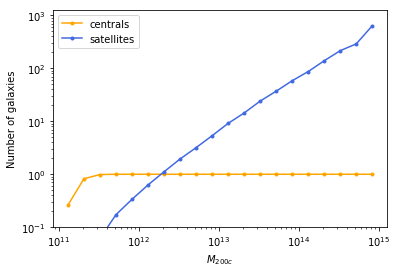

In [32]:
fig = plt.figure()
ax = plt.axes()
ax.plot((edges[1:]+edges[:-1])/2.,
           n_centrals_binned, #yerr = n_centrals_error, 
        color='orange', marker='o',markersize=3,
           label = 'centrals')

ax.plot((edges[1:]+edges[:-1])/2.,
           n_centrals_binned*n_satellites_binned, #yerr = n_satellites_error, 
             color='royalblue', marker='o',markersize=3,
        label = 'satellites')



ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel('Number of galaxies')
ax.set_xlabel(r'$M_{200c}$')
ax.set_ylim(1e-1)
plt.legend()

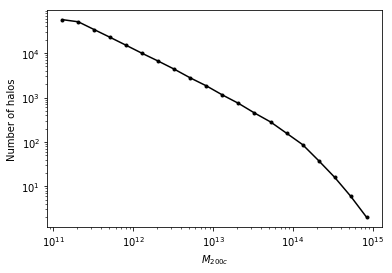

In [33]:
hmf.plot_halo_mass_function(no_duplicates_df['M200c'])

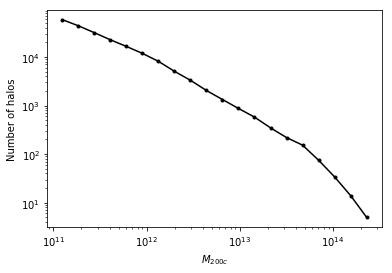

In [34]:
hmf.plot_halo_mass_function(no_duplicates_df['M200_HYDRO'])